In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit model expected input
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

### train

In [ ]:
import torch.nn.init as init

class CNN_basic(nn.Module):
    def __init__(self, num_layers, use_batch_norm=False, use_dropout=False, dropout_rate=0.5):
        super(CNN_basic, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3

        stack = num_layers // 3
        for i in range(3):
            out_channels = 32 * (2 ** i)
            layer = []
            for s in range(stack):
                conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                init.xavier_uniform_(conv.weight)  # Xavier initialization
                layer.append(conv)
                if use_batch_norm:
                    bn = nn.BatchNorm2d(out_channels)
                    init.constant_(bn.weight, 1)  # Initializing batch norm weights
                    init.constant_(bn.bias, 0)    # Initializing batch norm biases
                    layer.append(bn)
                layer.append(nn.ReLU())
                in_channels = out_channels

            layer.append(nn.MaxPool2d(kernel_size=2))
            self.layers.append(nn.Sequential(*layer))

        self.fc_input_size = in_channels * (224 // 2**(3)) ** 2
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else None
        self.fc = nn.Linear(self.fc_input_size, 10)
        init.xavier_uniform_(self.fc.weight)  # Xavier initialization for fully connected layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        if self.fc_dropout:
            x = self.fc_dropout(x)
        x = self.fc(x)
        return x


In [ ]:
class CNN_shallow(nn.Module):
    def __init__(self, num_layers):
        super(CNN_shallow, self).__init__()

        self.num_layers = num_layers

        # Define convolutional layers
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)])
        self.conv_layers.extend([nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1) for _ in range(num_layers - 1)])

        # Define a fully connected layer for classification
        self.fc = nn.Linear(64, 10)  # Assuming a 10-class classification problem

    def forward(self, x):
        # Apply convolutional layers
        for i in range(self.num_layers):
            x = F.relu(self.conv_layers[i](x))

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import torchvision.models as models

In [ ]:
def train_and_test(model_type, num_layers, use_batch_norm, use_dropout, dropout_rate, learning_rate, batch_size, epochs, reg):

  print("num_layers:", num_layers, "use_batch_norm:", use_batch_norm, "use_dropout:", use_dropout, "dropout_rate:", dropout_rate, "learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs, "reg:", reg)

  if model_type == 'basic':
    model = CNN_basic(num_layers=num_layers, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate=dropout_rate)
  elif model_type == 'shallow':
    model = CNN_shallow(num_layers=num_layers)
  elif model_type == 'resnet18':
    model = models.resnet18(pretrained=True)
  elif model_type == 'alexnet':
    model = models.alexnet(pretrained=True)
  elif model_type == 'vgg16':
    model = models.vgg16(pretrained=True)
  elif model_type == 'densenet':
    model = models.densenet161(pretrained=True)

  model.to(device)

  criterion = nn.CrossEntropyLoss()
  if reg:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
      for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        loss_val += loss.item()
      avg_loss_val = loss_val / len(test_dataset)
      avg_acc_val = correct_val / len(test_dataset)
      loss_hist_val.append(avg_loss_val)
      acc_hist_val.append(avg_acc_val)
    model.train()
    print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

  # pred_vec = []
  # correct = 0
  # model.eval()
  # with torch.no_grad():
  #     for data in test_loader:
  #         batch, labels = data
  #         batch, labels = batch.to(device), labels.to(device)
  #         outputs = model(batch)
  #         _, predicted = torch.max(outputs, 1)
  #         correct += (predicted == labels).sum().item()
  #         pred_vec.append(predicted)
  #     pred_vec = torch.cat(pred_vec)
  # accuracy = correct / len(test_dataset)
  accuracy = max(acc_hist_val)

  return loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy

# 1-1. layer

In [ ]:
layers_shallow_experiment_configs = [
    {"model_type": "shallow", "num_layers": 1, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 2, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 4, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 5, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 6, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
    {"model_type": "shallow", "num_layers": 7, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":70, "reg":False},
]
configs = layers_shallow_experiment_configs

In [ ]:
layers_legend = ["1 layers", "2 layers", "3 layers", "4 layers", "5 layers", "6 layers", "7 layers"]
epoch_losses = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    accuracies_per_config = []
    for _ in range(5):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      accuracies_per_config.append(accuracy)
    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)
    epoch_losses.append(avg_loss_hist)
    final_accuracies.append(avg_accuracy)

# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Different Layer Configurations")
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
layer_counts = [config["num_layers"] for config in configs]
plt.plot(layer_counts, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Layers")
plt.xticks(layer_counts)
plt.grid(True)
plt.show()


In [ ]:
layers_experiment_configs = [
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 6, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 9, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 12, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 15, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 18, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 21, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 24, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":100, "reg":False},
]
configs = layers_experiment_configs

In [ ]:
layers_legend = ["3 layers", "6 layers", "9 layers", "12 layers", "15 layers", "18 layers", "21 layers", "24 layers"]
epoch_losses = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    accuracies_per_config = []
    for _ in range(5):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      accuracies_per_config.append(accuracy)
    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)
    epoch_losses.append(avg_loss_hist)
    final_accuracies.append(avg_accuracy)

# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Different Layer Configurations")
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
layer_counts = [config["num_layers"] for config in configs]
plt.plot(layer_counts, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Layers")
plt.xticks(layer_counts)
plt.grid(True)
plt.show()


# 1-2.achitecture

In [ ]:
arc_experiment_configs = [
    {"model_type": "resnet18", "num_layers": 2, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":150, "reg":False},
    {"model_type": "alexnet", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":150, "reg":False},
    {"model_type": "vgg16", "num_layers": 4, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":150, "reg":False},
    {"model_type": "densenet", "num_layers": 6, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":150, "reg":False}
]
configs = arc_experiment_configs

num_layers: 2 use_batch_norm: False use_dropout: False dropout_rate: 0.5 learning_rate: 0.001 batch_size: 32 epochs: 150 reg: False


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.2MB/s]


[epoch 1] loss: 0.12586 accuracy: 0.5605   val loss: 0.12275 val accuracy: 0.5128
[epoch 2] loss: 0.00958 accuracy: 0.9172   val loss: 0.19727 val accuracy: 0.4615
[epoch 3] loss: 0.01936 accuracy: 0.8599   val loss: 0.30439 val accuracy: 0.4808
[epoch 4] loss: 0.00396 accuracy: 0.9682   val loss: 0.28581 val accuracy: 0.5962
[epoch 5] loss: 0.01259 accuracy: 0.9363   val loss: 0.13987 val accuracy: 0.6218
[epoch 6] loss: 0.00322 accuracy: 0.9745   val loss: 0.11079 val accuracy: 0.7308
[epoch 7] loss: 0.00221 accuracy: 0.9745   val loss: 0.07611 val accuracy: 0.6859
[epoch 8] loss: 0.00533 accuracy: 0.9682   val loss: 0.07526 val accuracy: 0.6923
[epoch 9] loss: 0.00527 accuracy: 0.9809   val loss: 0.15277 val accuracy: 0.5000
[epoch 10] loss: 0.00184 accuracy: 0.9809   val loss: 0.49526 val accuracy: 0.3654
[epoch 11] loss: 0.00700 accuracy: 0.9618   val loss: 0.05522 val accuracy: 0.7821
[epoch 12] loss: 0.00236 accuracy: 0.9873   val loss: 0.02365 val accuracy: 0.8718
[epoch 13] lo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 151MB/s]


[epoch 1] loss: 0.29479 accuracy: 0.0955   val loss: 0.12925 val accuracy: 0.1603
[epoch 2] loss: 0.10627 accuracy: 0.1210   val loss: 0.08993 val accuracy: 0.1346
[epoch 3] loss: 0.09035 accuracy: 0.1465   val loss: 0.07588 val accuracy: 0.2372
[epoch 4] loss: 0.08014 accuracy: 0.1592   val loss: 0.07848 val accuracy: 0.1923
[epoch 5] loss: 0.08146 accuracy: 0.1529   val loss: 0.06966 val accuracy: 0.2564
[epoch 6] loss: 0.06799 accuracy: 0.1975   val loss: 0.07187 val accuracy: 0.2436
[epoch 7] loss: 0.06875 accuracy: 0.3121   val loss: 0.06248 val accuracy: 0.3590
[epoch 8] loss: 0.06153 accuracy: 0.3439   val loss: 0.05974 val accuracy: 0.3654
[epoch 9] loss: 0.06305 accuracy: 0.3121   val loss: 0.05804 val accuracy: 0.3205
[epoch 10] loss: 0.05492 accuracy: 0.4140   val loss: 0.06020 val accuracy: 0.3782
[epoch 11] loss: 0.04815 accuracy: 0.4841   val loss: 0.07007 val accuracy: 0.3590
[epoch 12] loss: 0.05043 accuracy: 0.4204   val loss: 0.05472 val accuracy: 0.4551
[epoch 13] lo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 120MB/s]


[epoch 1] loss: 0.37508 accuracy: 0.0573   val loss: 0.15655 val accuracy: 0.0962
[epoch 2] loss: 0.14705 accuracy: 0.0573   val loss: 0.09710 val accuracy: 0.0962
[epoch 3] loss: 0.10241 accuracy: 0.1210   val loss: 0.08813 val accuracy: 0.1346
[epoch 4] loss: 0.08673 accuracy: 0.1210   val loss: 0.08051 val accuracy: 0.0962
[epoch 5] loss: 0.07783 accuracy: 0.1210   val loss: 0.07379 val accuracy: 0.1603
[epoch 6] loss: 0.07833 accuracy: 0.1210   val loss: 0.07431 val accuracy: 0.1667
[epoch 7] loss: 0.07496 accuracy: 0.1274   val loss: 0.07328 val accuracy: 0.1667
[epoch 8] loss: 0.07363 accuracy: 0.1529   val loss: 0.07146 val accuracy: 0.2372
[epoch 9] loss: 0.07171 accuracy: 0.1783   val loss: 0.07002 val accuracy: 0.2244
[epoch 10] loss: 0.07234 accuracy: 0.2293   val loss: 0.06940 val accuracy: 0.2179
[epoch 11] loss: 0.07387 accuracy: 0.1338   val loss: 0.07184 val accuracy: 0.2628
[epoch 12] loss: 0.06595 accuracy: 0.2548   val loss: 0.06976 val accuracy: 0.2756
[epoch 13] lo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 149MB/s]


[epoch 1] loss: 0.10046 accuracy: 0.6688   val loss: 0.68549 val accuracy: 0.2692
[epoch 2] loss: 0.00444 accuracy: 0.9554   val loss: 0.38328 val accuracy: 0.4487
[epoch 3] loss: 0.01314 accuracy: 0.9490   val loss: 0.95893 val accuracy: 0.3205
[epoch 4] loss: 0.02765 accuracy: 0.8535   val loss: 1.26893 val accuracy: 0.1859
[epoch 5] loss: 0.01714 accuracy: 0.8408   val loss: 0.63302 val accuracy: 0.3397
[epoch 6] loss: 0.01339 accuracy: 0.9172   val loss: 0.21416 val accuracy: 0.5064
[epoch 7] loss: 0.00560 accuracy: 0.9682   val loss: 0.16902 val accuracy: 0.4808
[epoch 8] loss: 0.01205 accuracy: 0.9363   val loss: 0.45118 val accuracy: 0.3397
[epoch 9] loss: 0.01460 accuracy: 0.9172   val loss: 0.33121 val accuracy: 0.4679
[epoch 10] loss: 0.01621 accuracy: 0.9108   val loss: 0.18327 val accuracy: 0.6026
[epoch 11] loss: 0.00376 accuracy: 0.9427   val loss: 0.06391 val accuracy: 0.7244
[epoch 12] loss: 0.00718 accuracy: 0.9490   val loss: 0.20942 val accuracy: 0.5128
[epoch 13] lo

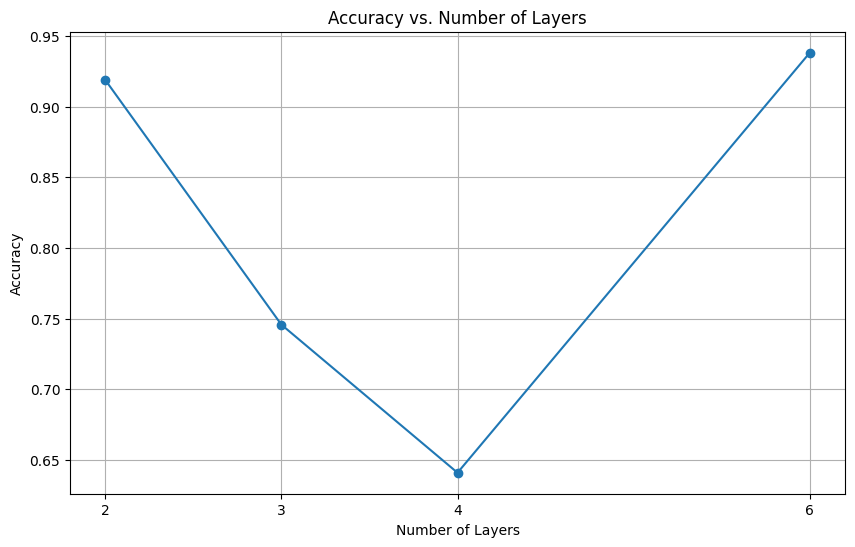

In [ ]:
layers_legend = ["resnet18", "alexnet", "vgg16", "densenet"]
epoch_losses = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    accuracies_per_config = []
    for _ in range(3):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      accuracies_per_config.append(accuracy)
    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)
    epoch_losses.append(avg_loss_hist)
    final_accuracies.append(avg_accuracy)

# Plot : Accuracy vs. achitecture
plt.figure(figsize=(10, 6))
layer_counts = [config["num_layers"] for config in configs]
plt.plot(layer_counts, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Layers")
plt.xticks(layer_counts)
plt.grid(True)
plt.show()


In [ ]:
layers_legend = ["resnet18", "alexnet", "vgg16", "densenet"]
# epoch_losses = []
# final_accuracies = []
# for config in configs:
#     losses_per_config = []
#     accuracies_per_config = []
#     for _ in range(3):
#       loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
#       losses_per_config.append(loss_hist)
#       accuracies_per_config.append(accuracy)
#     avg_loss_hist = np.mean(losses_per_config, axis=0)
#     avg_accuracy = np.mean(accuracies_per_config)
#     epoch_losses.append(avg_loss_hist)
#     final_accuracies.append(avg_accuracy)

# Plot : Accuracy vs. achitecture
plt.figure(figsize=(10, 6))
models = ["resnet18", "alexnet", "vgg16", "densenet"]
plt.plot(models, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Various Architectures")
#plt.xticks(layer_counts)
plt.grid(True)
plt.show()

# 2 BN

In [ ]:
import torch.nn.init as init

class CNN_basic_batch(nn.Module):
    def __init__(self, num_layers, use_batch_norm=False, use_batch_norm_1d=False, use_dropout=False, dropout_rate=0.5):
        super(CNN_basic_batch, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3

        stack = num_layers // 3
        for i in range(3):
            out_channels = 32 * (2 ** i)
            layer = []
            for s in range(stack):
                conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                #init.xavier_uniform_(conv.weight)  # Xavier initialization
                layer.append(conv)
                if use_batch_norm:
                    bn = nn.BatchNorm2d(out_channels)
                    init.constant_(bn.weight, 1)  # Initializing batch norm weights
                    init.constant_(bn.bias, 0)    # Initializing batch norm biases
                    layer.append(bn)
                layer.append(nn.ReLU())
                in_channels = out_channels

            layer.append(nn.MaxPool2d(kernel_size=2))
            self.layers.append(nn.Sequential(*layer))

        self.use_batch_norm_1d = use_batch_norm_1d


        self.fc_input_size = in_channels * (224 // 2**(3)) ** 2
        if use_batch_norm_1d:
            self.fc_bn = nn.BatchNorm1d(self.fc_input_size)
            init.constant_(self.fc_bn.weight, 1)  # Initializing batch norm weights
            init.constant_(self.fc_bn.bias, 0)
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else None
        self.fc = nn.Linear(self.fc_input_size, 10)
        init.xavier_uniform_(self.fc.weight)  # Xavier initialization for fully connected layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        if self.use_batch_norm_1d:
            x = self.fc_bn(x)
        if self.fc_dropout:
            x = self.fc_dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def train_and_test(model_type, num_layers, use_batch_norm, use_batch_norm_1d, use_dropout, dropout_rate, learning_rate, batch_size, epochs, reg):

  print("num_layers:", num_layers, "use_batch_norm:", use_batch_norm, "use_dropout:", use_dropout, "dropout_rate:", dropout_rate, "learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs, "reg:", reg)

  if model_type == 'basic':
    model = CNN_basic(num_layers=num_layers, use_batch_norm=use_batch_norm, use_batch_norm_1d=use_batch_norm_1d, use_dropout=use_dropout, dropout_rate=dropout_rate)
  if model_type == 'batch':
    model = CNN_basic_batch(num_layers=num_layers, use_batch_norm=use_batch_norm, use_batch_norm_1d=use_batch_norm_1d, use_dropout=use_dropout, dropout_rate=dropout_rate)
  elif model_type == 'shallow':
    model = CNN_shallow(num_layers=num_layers)
  elif model_type == 'resnet18':
    model = models.resnet18(pretrained=True)
  elif model_type == 'alexnet':
    model = models.alexnet(pretrained=True)
  elif model_type == 'vgg16':
    model = models.vgg16(pretrained=True)
  elif model_type == 'densenet':
    model = models.densenet161(pretrained=True)

  model.to(device)

  criterion = nn.CrossEntropyLoss()
  if reg:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
      for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        loss_val += loss.item()
      avg_loss_val = loss_val / len(test_loader)
      avg_acc_val = correct_val / len(test_dataset)
      loss_hist_val.append(avg_loss_val)
      acc_hist_val.append(avg_acc_val)
    model.train()
    print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

  # pred_vec = []
  # correct = 0
  # model.eval()
  # with torch.no_grad():
  #     for data in test_loader:
  #         batch, labels = data
  #         batch, labels = batch.to(device), labels.to(device)
  #         outputs = model(batch)
  #         _, predicted = torch.max(outputs, 1)
  #         correct += (predicted == labels).sum().item()
  #         pred_vec.append(predicted)
  #     pred_vec = torch.cat(pred_vec)
  # accuracy = correct / len(test_dataset)
  accuracy = max(acc_hist_val)

  return loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy

In [ ]:
bn_experiment_configs = [
    {"model_type": "batch", "num_layers": 3, "use_batch_norm": False, "use_batch_norm_1d": False,"use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "batch", "num_layers": 3, "use_batch_norm": True, "use_batch_norm_1d": False,"use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "batch", "num_layers": 3, "use_batch_norm": False, "use_batch_norm_1d": True,"use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "batch", "num_layers": 3, "use_batch_norm": True, "use_batch_norm_1d": True,"use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 64, "epochs":50, "reg":False},
]
configs = bn_experiment_configs

num_layers: 3 use_batch_norm: False use_dropout: False dropout_rate: 0.3 learning_rate: 0.001 batch_size: 64 epochs: 50 reg: False
[epoch 1] loss: 0.08514 accuracy: 0.1210   val loss: 2.58949 val accuracy: 0.2949
[epoch 2] loss: 0.03942 accuracy: 0.3185   val loss: 2.21241 val accuracy: 0.2564
[epoch 3] loss: 0.03338 accuracy: 0.3949   val loss: 1.78960 val accuracy: 0.3654
[epoch 4] loss: 0.02450 accuracy: 0.5987   val loss: 1.65422 val accuracy: 0.4359
[epoch 5] loss: 0.01786 accuracy: 0.7643   val loss: 1.84415 val accuracy: 0.5064
[epoch 6] loss: 0.01268 accuracy: 0.8280   val loss: 1.82945 val accuracy: 0.5256
[epoch 7] loss: 0.00697 accuracy: 0.9108   val loss: 1.87613 val accuracy: 0.5641
[epoch 8] loss: 0.00678 accuracy: 0.9299   val loss: 2.11649 val accuracy: 0.5897
[epoch 9] loss: 0.00255 accuracy: 0.9554   val loss: 2.37922 val accuracy: 0.4936
[epoch 10] loss: 0.00230 accuracy: 0.9554   val loss: 2.06287 val accuracy: 0.5577
[epoch 11] loss: 0.00118 accuracy: 1.0000   val 

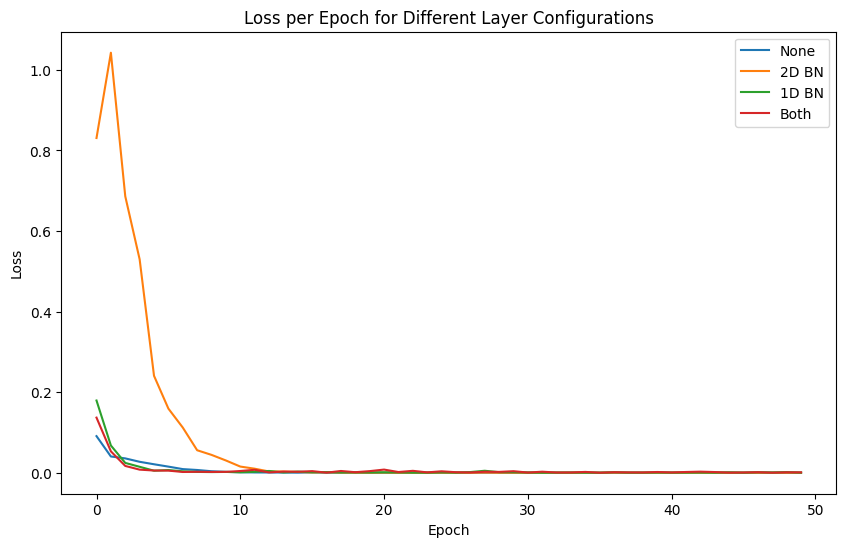

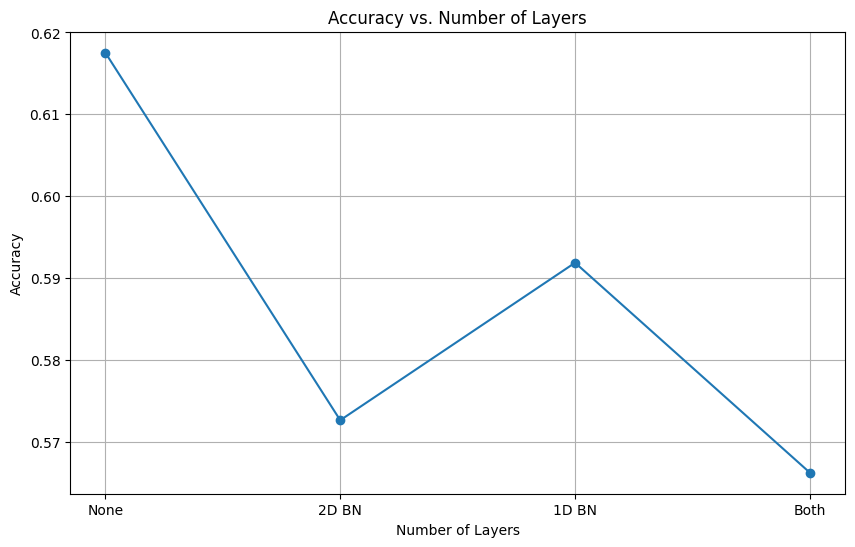

In [ ]:
layers_legend = ["None", "2D BN", "1D BN", "Both"]
epoch_losses = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    accuracies_per_config = []
    for _ in range(3):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      accuracies_per_config.append(accuracy)
    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)
    epoch_losses.append(avg_loss_hist)
    final_accuracies.append(avg_accuracy)

# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Different Layer Configurations")
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
plt.plot(layers_legend, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Layers")
plt.xticks(layers_legend)
plt.grid(True)
plt.show()


# 3 Regularization


In [ ]:
regularization_experiment_configs = [
    {"model_type": "basic", "num_layers": 6, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 6, "use_batch_norm": False, "use_dropout": True, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":100, "reg":False},
    {"model_type": "basic", "num_layers": 6, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":100, "reg":True},
    {"model_type": "basic", "num_layers": 6, "use_batch_norm": False, "use_dropout": True, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":100, "reg":True},
]
configs = regularization_experiment_configs

num_layers: 6 use_batch_norm: False use_dropout: False dropout_rate: 0.3 learning_rate: 0.001 batch_size: 4 epochs: 100 reg: False
[epoch 1] loss: 0.60274 accuracy: 0.1338   val loss: 0.54061 val accuracy: 0.2692
[epoch 2] loss: 0.48978 accuracy: 0.3631   val loss: 0.43302 val accuracy: 0.5128
[epoch 3] loss: 0.36215 accuracy: 0.5541   val loss: 0.44505 val accuracy: 0.4295
[epoch 4] loss: 0.29400 accuracy: 0.6561   val loss: 0.57455 val accuracy: 0.4423
[epoch 5] loss: 0.14050 accuracy: 0.8089   val loss: 0.49713 val accuracy: 0.3974
[epoch 6] loss: 0.10279 accuracy: 0.8599   val loss: 1.12391 val accuracy: 0.4231
[epoch 7] loss: 0.07408 accuracy: 0.9299   val loss: 0.88750 val accuracy: 0.4231
[epoch 8] loss: 0.02624 accuracy: 0.9554   val loss: 1.01442 val accuracy: 0.4359
[epoch 9] loss: 0.00648 accuracy: 0.9936   val loss: 1.30358 val accuracy: 0.4679
[epoch 10] loss: 0.00109 accuracy: 1.0000   val loss: 1.19417 val accuracy: 0.4872
[epoch 11] loss: 0.00029 accuracy: 1.0000   val 

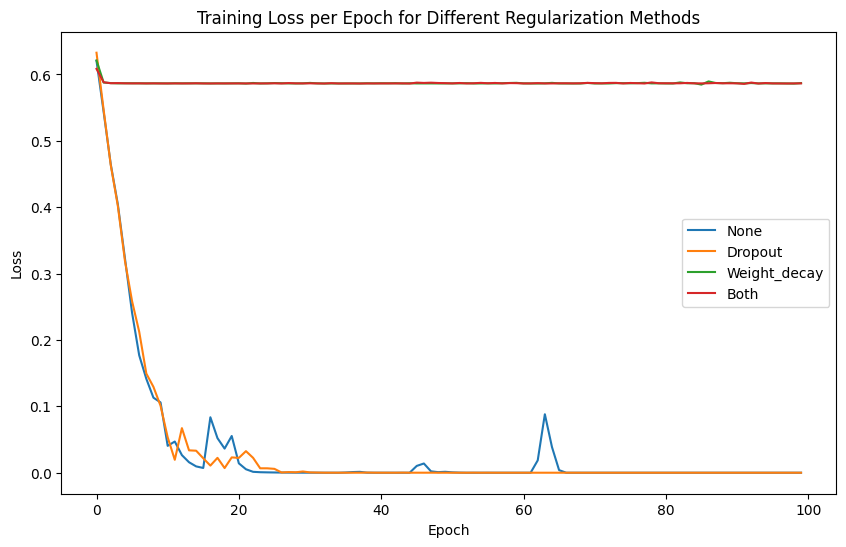

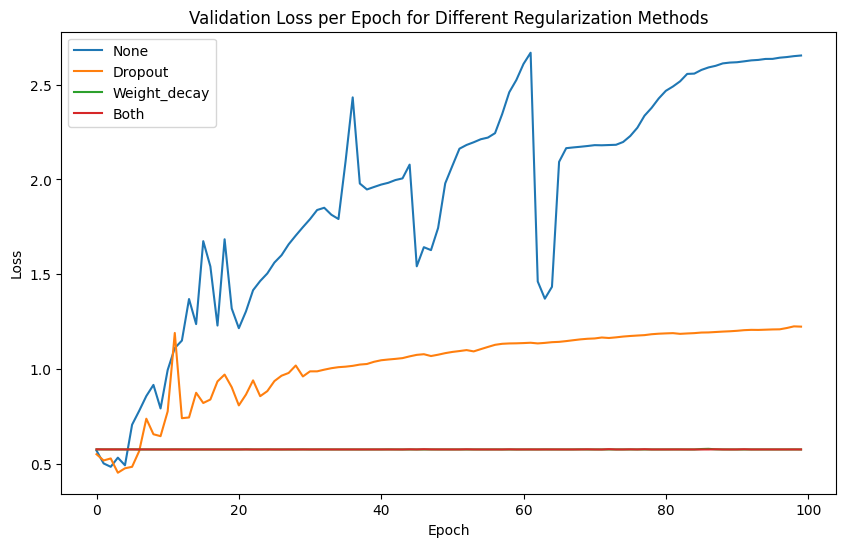

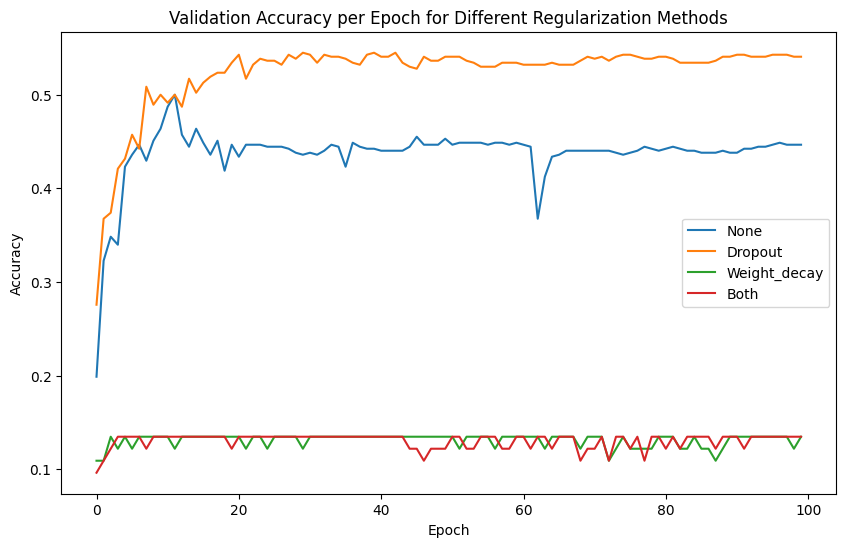

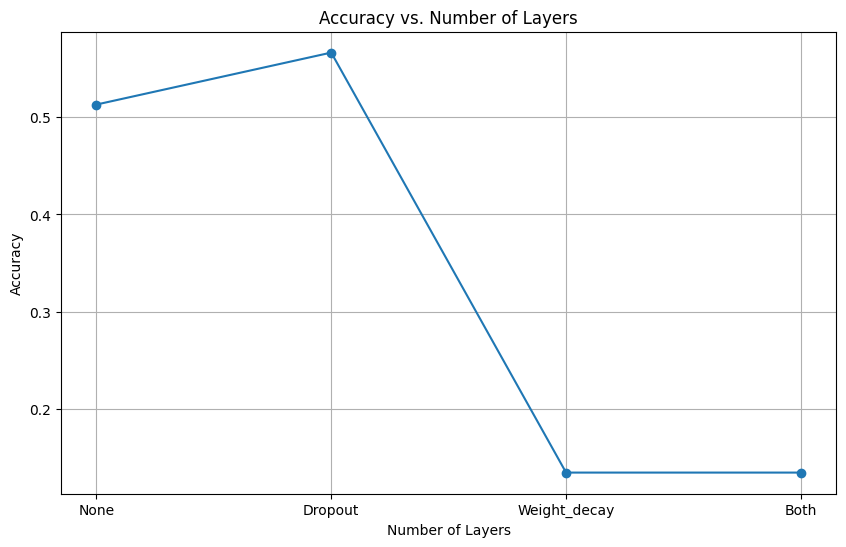

In [ ]:
layers_legend = ["None", "Dropout", "Weight_decay", "Both"]
epoch_losses = []
epoch_losses_val = []
epoch_acc_val = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    losses_per_config_val = []
    acc_per_epoch = []
    accuracies_per_config = []
    for _ in range(3):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      losses_per_config_val.append(loss_hist_val)
      acc_per_epoch.append(acc_hist_val)
      accuracies_per_config.append(accuracy)

    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_loss_hist_val = np.mean(losses_per_config_val, axis=0)
    avg_accuracy_val = np.mean(acc_per_epoch, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)

    epoch_losses.append(avg_loss_hist)
    epoch_losses_val.append(avg_loss_hist_val)
    epoch_acc_val.append(avg_accuracy_val)
    final_accuracies.append(avg_accuracy)

# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch for Different Regularization Methods")
plt.legend()
plt.show()

# Plot 2: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses_val):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch for Different Regularization Methods")
plt.legend()
plt.show()

# Plot 2: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, acc_hist in enumerate(epoch_acc_val):
    plt.plot(acc_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch for Different Regularization Methods")
plt.legend()
plt.show()

# Plot 3: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
plt.plot(layers_legend, final_accuracies, marker='o')
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Layers")
plt.grid(True)
plt.show()

# Loss

In [4]:
import torch.nn.init as init

class CNN_basic(nn.Module):
    def __init__(self, num_layers, use_batch_norm=False, use_dropout=False, dropout_rate=0.5):
        super(CNN_basic, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3

        stack = num_layers // 3
        for i in range(3):
            out_channels = 32 * (2 ** i)
            layer = []
            for s in range(stack):
                conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                init.xavier_uniform_(conv.weight)  # Xavier initialization
                layer.append(conv)
                if use_batch_norm:
                    bn = nn.BatchNorm2d(out_channels)
                    init.constant_(bn.weight, 1)  # Initializing batch norm weights
                    init.constant_(bn.bias, 0)    # Initializing batch norm biases
                    layer.append(bn)
                layer.append(nn.ReLU())
                in_channels = out_channels

            layer.append(nn.MaxPool2d(kernel_size=2))
            self.layers.append(nn.Sequential(*layer))

        self.fc_input_size = in_channels * (224 // 2**(3)) ** 2
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else None
        self.fc = nn.Linear(self.fc_input_size, 10)
        init.xavier_uniform_(self.fc.weight)  # Xavier initialization for fully connected layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        if self.fc_dropout:
            x = self.fc_dropout(x)
        x = self.fc(x)
        return x


In [5]:
def train_and_test(model_type, num_layers, use_batch_norm, use_dropout, dropout_rate, learning_rate, batch_size, epochs, reg):

  print("num_layers:", num_layers, "use_batch_norm:", use_batch_norm, "use_dropout:", use_dropout, "dropout_rate:", dropout_rate, "learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs, "reg:", reg)

  if model_type == 'basic':
    model = CNN_basic(num_layers=num_layers, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate=dropout_rate)
  elif model_type == 'shallow':
    model = CNN_shallow(num_layers=num_layers)
  elif model_type == 'resnet18':
    model = models.resnet18(pretrained=True)
  elif model_type == 'alexnet':
    model = models.alexnet(pretrained=True)
  elif model_type == 'vgg16':
    model = models.vgg16(pretrained=True)
  elif model_type == 'densenet':
    model = models.densenet161(pretrained=True)

  model.to(device)

  criterion = nn.CrossEntropyLoss()
  if reg:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
      for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        loss_val += loss.item()
      avg_loss_val = loss_val / len(test_dataset)
      avg_acc_val = correct_val / len(test_dataset)
      loss_hist_val.append(avg_loss_val)
      acc_hist_val.append(avg_acc_val)
    model.train()
    print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

  # pred_vec = []
  # correct = 0
  # model.eval()
  # with torch.no_grad():
  #     for data in test_loader:
  #         batch, labels = data
  #         batch, labels = batch.to(device), labels.to(device)
  #         outputs = model(batch)
  #         _, predicted = torch.max(outputs, 1)
  #         correct += (predicted == labels).sum().item()
  #         pred_vec.append(predicted)
  #     pred_vec = torch.cat(pred_vec)
  # accuracy = correct / len(test_dataset)
  accuracy = max(acc_hist_val)

  return loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy

In [6]:
class SquaredHingeLoss(nn.Module):
    def __init__(self):
        super(SquaredHingeLoss, self).__init__()

    def forward(self, outputs, labels):
        num_classes = outputs.size(1)
        correct_labels = torch.zeros_like(outputs).scatter_(1, labels.unsqueeze(1), 1)
        margins = torch.clamp(1 - (correct_labels * 2 - 1) * outputs, min=0)
        loss = torch.mean(torch.pow(margins, 2))
        return loss

In [7]:
def train_and_test_hinge(model_type, num_layers, use_batch_norm, use_dropout, dropout_rate, learning_rate, batch_size, epochs, reg):

  print("num_layers:", num_layers, "use_batch_norm:", use_batch_norm, "use_dropout:", use_dropout, "dropout_rate:", dropout_rate, "learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs, "reg:", reg)

  if model_type == 'basic':
    model = CNN_basic(num_layers=num_layers, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate=dropout_rate)
  elif model_type == 'shallow':
    model = CNN_shallow(num_layers=num_layers)
  elif model_type == 'resnet18':
    model = models.resnet18(pretrained=True)
  elif model_type == 'alexnet':
    model = models.alexnet(pretrained=True)
  elif model_type == 'vgg16':
    model = models.vgg16(pretrained=True)
  elif model_type == 'densenet':
    model = models.densenet161(pretrained=True)

  model.to(device)

  criterion = SquaredHingeLoss()
  if reg:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
      for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        loss_val += loss.item()
      avg_loss_val = loss_val / len(test_dataset)
      avg_acc_val = correct_val / len(test_dataset)
      loss_hist_val.append(avg_loss_val)
      acc_hist_val.append(avg_acc_val)
    model.train()
    print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

  # pred_vec = []
  # correct = 0
  # model.eval()
  # with torch.no_grad():
  #     for data in test_loader:
  #         batch, labels = data
  #         batch, labels = batch.to(device), labels.to(device)
  #         outputs = model(batch)
  #         _, predicted = torch.max(outputs, 1)
  #         correct += (predicted == labels).sum().item()
  #         pred_vec.append(predicted)
  #     pred_vec = torch.cat(pred_vec)
  # accuracy = correct / len(test_dataset)
  accuracy = max(acc_hist_val)

  return loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy

In [10]:
config = {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":50, "reg":False}

num_layers: 3 use_batch_norm: False use_dropout: False dropout_rate: 0.3 learning_rate: 0.001 batch_size: 4 epochs: 50 reg: False
[epoch 1] loss: 0.82019 accuracy: 0.2293   val loss: 0.45725 val accuracy: 0.3974
[epoch 2] loss: 0.43269 accuracy: 0.4650   val loss: 0.48614 val accuracy: 0.4679
[epoch 3] loss: 0.28029 accuracy: 0.6561   val loss: 0.46051 val accuracy: 0.4551
[epoch 4] loss: 0.14422 accuracy: 0.8344   val loss: 0.46409 val accuracy: 0.4936
[epoch 5] loss: 0.06343 accuracy: 0.9108   val loss: 0.48251 val accuracy: 0.5256
[epoch 6] loss: 0.00999 accuracy: 0.9873   val loss: 0.44350 val accuracy: 0.6090
[epoch 7] loss: 0.00106 accuracy: 1.0000   val loss: 0.46422 val accuracy: 0.6282
[epoch 8] loss: 0.00027 accuracy: 1.0000   val loss: 0.49681 val accuracy: 0.6346
[epoch 9] loss: 0.00022 accuracy: 1.0000   val loss: 0.50128 val accuracy: 0.6282
[epoch 10] loss: 0.00014 accuracy: 1.0000   val loss: 0.50300 val accuracy: 0.6218
[epoch 11] loss: 0.00011 accuracy: 1.0000   val l

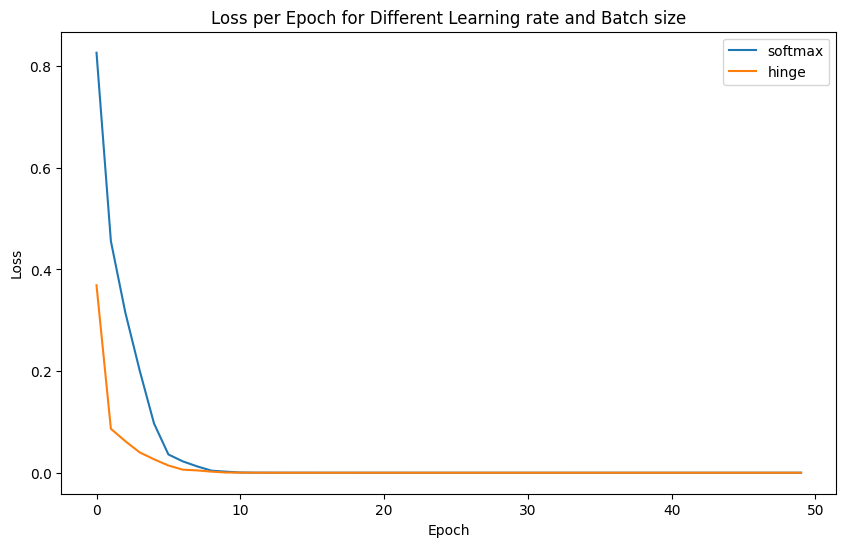

NameError: ignored

<Figure size 1000x600 with 0 Axes>

In [11]:
layers_legend = ["softmax", "hinge"]
epoch_losses = []
final_accuracies = []

losses_per_config = []
accuracies_per_config = []
for _ in range(3):
  loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
  losses_per_config.append(loss_hist)
  accuracies_per_config.append(accuracy)
avg_loss_hist = np.mean(losses_per_config, axis=0)
avg_accuracy = np.mean(accuracies_per_config)
epoch_losses.append(avg_loss_hist)
final_accuracies.append(avg_accuracy)

losses_per_config = []
accuracies_per_config = []
for _ in range(3):
  loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test_hinge(**config)
  losses_per_config.append(loss_hist)
  accuracies_per_config.append(accuracy)
avg_loss_hist = np.mean(losses_per_config, axis=0)
avg_accuracy = np.mean(accuracies_per_config)
epoch_losses.append(avg_loss_hist)
final_accuracies.append(avg_accuracy)


# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Different Learning rate and Batch size")
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
plt.plot(layers_legend, final_accuracies, marker='o')
plt.xlabel("lr, batch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate and Batch size")
plt.xticks(layers_legend)
#plt.grid(True)
plt.show()


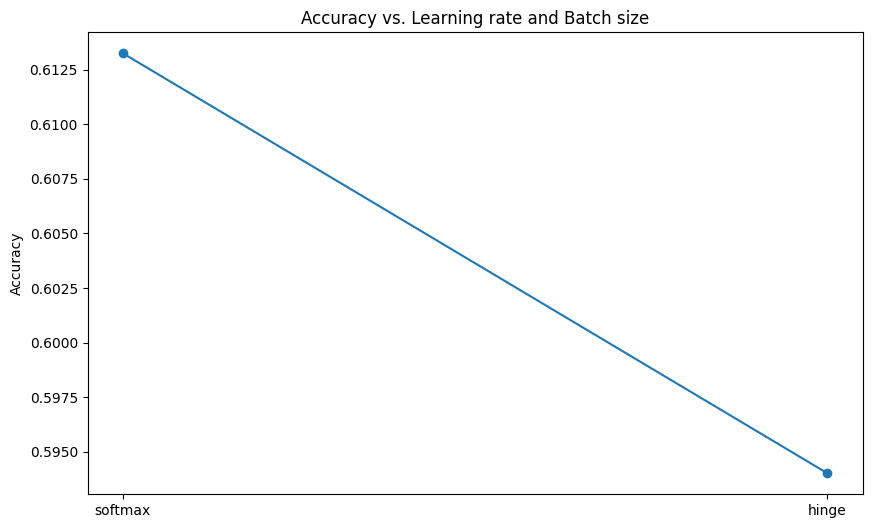

In [13]:
# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
plt.plot(layers_legend, final_accuracies, marker='o')
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate and Batch size")
plt.xticks(layers_legend)
#plt.grid(True)
plt.show()

# learning reate, batch

In [ ]:
layers_experiment_configs = [
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.25e-3, "batch_size": 32, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.5e-3, "batch_size": 32, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 32, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 2e-3, "batch_size": 32, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.25e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.5e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 2e-3, "batch_size": 64, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.25e-3, "batch_size": 128, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 0.5e-3, "batch_size": 128, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 1e-3, "batch_size": 128, "epochs":50, "reg":False},
    {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.5, "learning_rate": 2e-3, "batch_size": 128, "epochs":50, "reg":False},
]
configs = layers_experiment_configs

num_layers: 3 use_batch_norm: False use_dropout: False dropout_rate: 0.5 learning_rate: 0.00025 batch_size: 32 epochs: 50 reg: False
[epoch 1] loss: 0.09376 accuracy: 0.1847   val loss: 0.06799 val accuracy: 0.2500
[epoch 2] loss: 0.05980 accuracy: 0.3185   val loss: 0.05981 val accuracy: 0.3141
[epoch 3] loss: 0.04771 accuracy: 0.6051   val loss: 0.05535 val accuracy: 0.4744
[epoch 4] loss: 0.03392 accuracy: 0.7771   val loss: 0.04824 val accuracy: 0.5577
[epoch 5] loss: 0.02411 accuracy: 0.8280   val loss: 0.04473 val accuracy: 0.5513
[epoch 6] loss: 0.01475 accuracy: 0.9108   val loss: 0.04301 val accuracy: 0.5769
[epoch 7] loss: 0.00700 accuracy: 0.9873   val loss: 0.04459 val accuracy: 0.5577
[epoch 8] loss: 0.00402 accuracy: 0.9936   val loss: 0.04318 val accuracy: 0.6218
[epoch 9] loss: 0.00202 accuracy: 1.0000   val loss: 0.04173 val accuracy: 0.6026
[epoch 10] loss: 0.00097 accuracy: 1.0000   val loss: 0.04743 val accuracy: 0.5962
[epoch 11] loss: 0.00057 accuracy: 1.0000   va

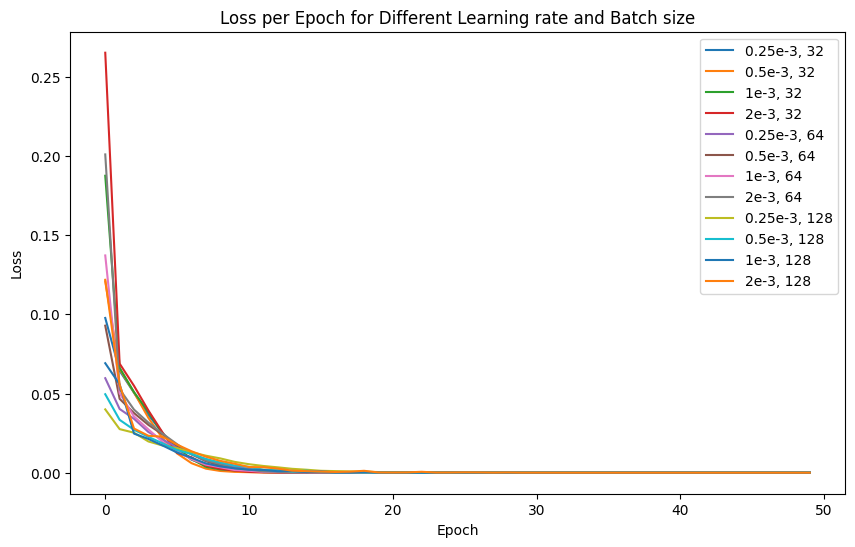

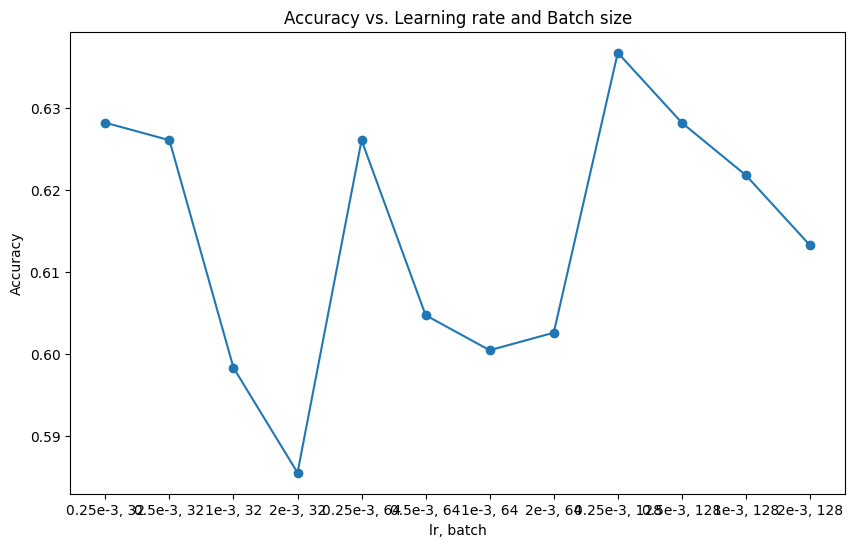

In [ ]:
layers_legend = ["0.25e-3, 32", "0.5e-3, 32", "1e-3, 32", "2e-3, 32", "0.25e-3, 64", "0.5e-3, 64", "1e-3, 64", "2e-3, 64", "0.25e-3, 128", "0.5e-3, 128", "1e-3, 128", "2e-3, 128"]
epoch_losses = []
final_accuracies = []
for config in configs:
    losses_per_config = []
    accuracies_per_config = []
    for _ in range(3):
      loss_hist, acc_hist, loss_hist_val, acc_hist_val, accuracy = train_and_test(**config)
      losses_per_config.append(loss_hist)
      accuracies_per_config.append(accuracy)
    avg_loss_hist = np.mean(losses_per_config, axis=0)
    avg_accuracy = np.mean(accuracies_per_config)
    epoch_losses.append(avg_loss_hist)
    final_accuracies.append(avg_accuracy)

# Plot 1: Loss per Epoch for Different Layer Configurations
plt.figure(figsize=(10, 6))
for i, loss_hist in enumerate(epoch_losses):
    plt.plot(loss_hist, label=layers_legend[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Different Learning rate and Batch size")
plt.legend()
plt.show()

# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(10, 6))
layer_counts = [config["num_layers"] for config in configs]
plt.plot(layers_legend, final_accuracies, marker='o')
plt.xlabel("lr, batch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate and Batch size")
#plt.xticks(layers_legend)
#plt.grid(True)
plt.show()


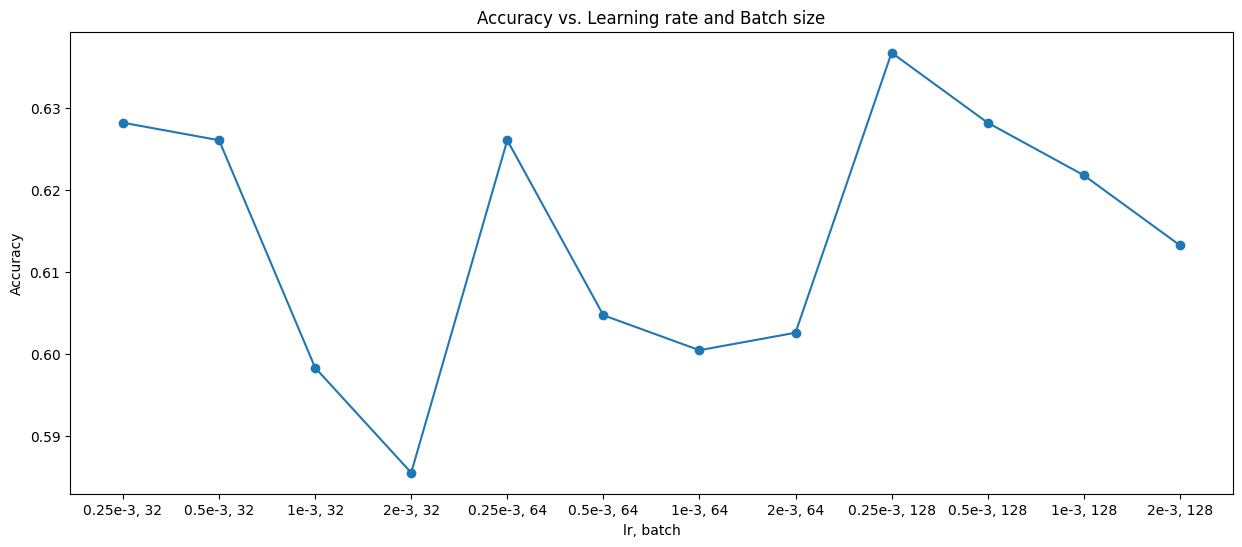

In [ ]:
# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(15, 6))
layer_counts = [config["num_layers"] for config in configs]
plt.plot(layers_legend, final_accuracies, marker='o')
plt.xlabel("lr, batch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning rate and Batch size")
#plt.xticks(layers_legend)
#plt.grid(True)
plt.show()

# compress

In [48]:
import torch.nn.init as init

class CNN_basic(nn.Module):
    def __init__(self, num_layers, use_batch_norm=False, use_dropout=False, dropout_rate=0.5):
        super(CNN_basic, self).__init__()

        self.layers = nn.ModuleList()
        in_channels = 3

        stack = num_layers // 3
        for i in range(3):
            out_channels = 32 * (2 ** i)
            layer = []
            for s in range(stack):
                conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                init.xavier_uniform_(conv.weight)  # Xavier initialization
                layer.append(conv)
                if use_batch_norm:
                    bn = nn.BatchNorm2d(out_channels)
                    init.constant_(bn.weight, 1)  # Initializing batch norm weights
                    init.constant_(bn.bias, 0)    # Initializing batch norm biases
                    layer.append(bn)
                layer.append(nn.ReLU())
                in_channels = out_channels

            layer.append(nn.MaxPool2d(kernel_size=2))
            self.layers.append(nn.Sequential(*layer))

        self.fc_input_size = in_channels * (224 // 2**(3)) ** 2
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else None
        self.fc = nn.Linear(self.fc_input_size, 10)
        init.xavier_uniform_(self.fc.weight)  # Xavier initialization for fully connected layer

        self.original = None

    def compress_fc_layer(self, svd_rank):
        if self.original == None:
          self.original = self.fc.weight.data.clone()
        U, S, V = torch.svd(self.original)
        rank = min(svd_rank, U.size(1), V.size(1))

        # 랭크에 맞게 U, S, V 조정
        S_approx = torch.diag(S)
        S_approx[rank:, rank:] = 0

        weight_approx = torch.mm(U, torch.mm(S_approx, V.mT))

        self.fc.weight.data = weight_approx

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        if self.fc_dropout:
            x = self.fc_dropout(x)
        x = self.fc(x)
        return x


In [49]:
def train_and_test_hinge_compress(model_type, num_layers, use_batch_norm, use_dropout, dropout_rate, learning_rate, batch_size, epochs, reg):

  print("num_layers:", num_layers, "use_batch_norm:", use_batch_norm, "use_dropout:", use_dropout, "dropout_rate:", dropout_rate, "learning_rate:", learning_rate, "batch_size:", batch_size, "epochs:", epochs, "reg:", reg)

  if model_type == 'basic':
    model = CNN_basic(num_layers=num_layers, use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate=dropout_rate)
  elif model_type == 'shallow':
    model = CNN_shallow(num_layers=num_layers)
  elif model_type == 'resnet18':
    model = models.resnet18(pretrained=True)
  elif model_type == 'alexnet':
    model = models.alexnet(pretrained=True)
  elif model_type == 'vgg16':
    model = models.vgg16(pretrained=True)
  elif model_type == 'densenet':
    model = models.densenet161(pretrained=True)

  model.to(device)

  criterion = nn.CrossEntropyLoss()
  if reg:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)
    print(epoch + 1, avg_loss, avg_acc)

  return model, test_dataset, test_loader

In [50]:
config = {"model_type": "basic", "num_layers": 3, "use_batch_norm": False, "use_dropout": False, "dropout_rate": 0.3, "learning_rate": 1e-3, "batch_size": 4, "epochs":50, "reg":False}

In [ ]:
model, test_dataset, test_loader = train_and_test_hinge_compress(**config)

10 10
10 10
10 10
10 10
10 10
10 10
10 10
10 10


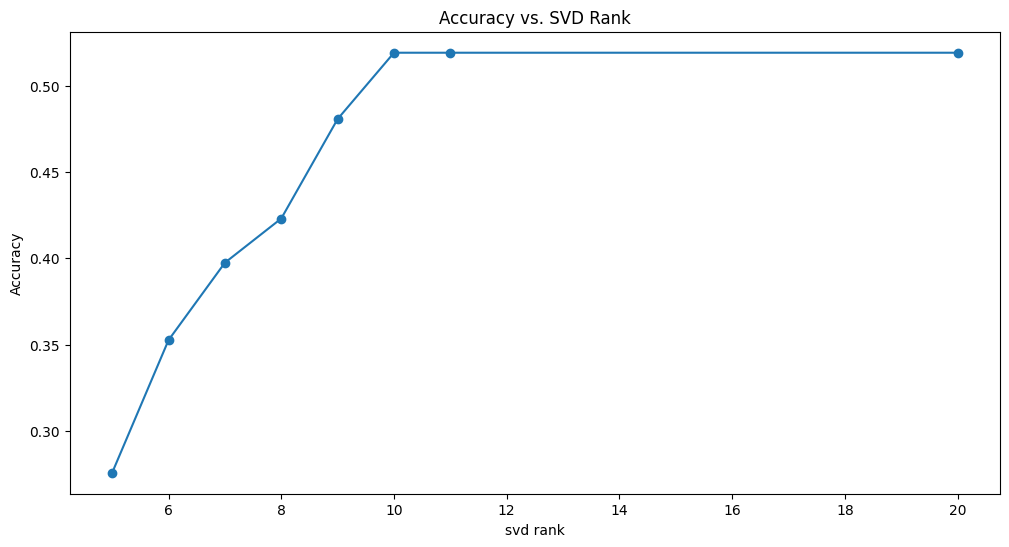

In [57]:
ranks = [5, 6, 7, 8, 9, 10, 11, 20]
accuracysss = []

criterion = nn.CrossEntropyLoss()

for rank in ranks:
  model.eval()
  loss_val = 0.0
  correct_val = 0
  avg_accuracy = 0
  avg_compress_accuracy = 0

  # compress
  model.compress_fc_layer(rank)
  model.eval()
  loss_val = 0.0
  correct_val = 0
  with torch.no_grad():
    for data in test_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = model(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(test_dataset)
    avg_acc_val = correct_val / len(test_dataset)
  compress_accuracy = avg_acc_val
  accuracysss.append(compress_accuracy)


# Plot 2: Accuracy vs. Number of Layers
plt.figure(figsize=(12, 6))
plt.plot(ranks, accuracysss, marker='o')
plt.xlabel("svd rank")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. SVD Rank")
#plt.xticks(layers_legend)
#plt.grid(True)
plt.show()

# Best accuracy

In [58]:
import torchvision.models as models
def pretrain(pre_epochs = 50):
  model = models.densenet161(pretrained=True)
  model.to(device)

  batch_size = 128
  epochs = 200

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

  train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
  train_add_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/remain', transform=transform)
  test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  train_add_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  loss_hist, acc_hist = [], []
  loss_hist_val, acc_hist_val = [], []

  # pretrain
  for epoch in range(pre_epochs):
    for data in train_add_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    print(epoch+1)


  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += loss.item()

    scheduler.step()

    avg_loss = running_loss / total
    avg_acc = correct / total
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    model.eval()
    loss_val = 0.0
    correct_val = 0

    with torch.no_grad():
      for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_val += (predicted == labels).sum().item()
        loss_val += loss.item()
      avg_loss_val = loss_val / len(test_dataset)
      avg_acc_val = correct_val / len(test_dataset)
      loss_hist_val.append(avg_loss_val)
      acc_hist_val.append(avg_acc_val)
    model.train()
    print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

  # pred_vec = []
  # correct = 0
  # model.eval()
  # with torch.no_grad():
  #     for data in test_loader:
  #         batch, labels = data
  #         batch, labels = batch.to(device), labels.to(device)
  #         outputs = model(batch)
  #         _, predicted = torch.max(outputs, 1)
  #         correct += (predicted == labels).sum().item()
  #         pred_vec.append(predicted)
  #     pred_vec = torch.cat(pred_vec)
  # accuracy = correct / len(test_dataset)
  accuracy = max(acc_hist_val)

  return accuracy

In [59]:
pre_epochs = [0, 5, 10, 15]

In [60]:
accuracy = []
for pre_epoch in pre_epochs:
  accuracy.append(pretrain(pre_epoch))
print(accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 167MB/s] 


OutOfMemoryError: ignored